In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tensorboardX import SummaryWriter
import os.path as osp
import os
from pathlib import Path
import scipy.misc as Misc

In [2]:
torch.cuda.is_available()

True

In [3]:
global config, params
config = {
    'svhn_path':'/home/abhirup/Datasets/svhn/',
    'mnist_path':'/home/abhirup/Datasets/mnist/',
    'batch_size': 100,
    'num_workers': 8,
    'image_size': 32,
    'images_path': './saved_pics2/',
    'model_path': './saved_model/',
    'use_cuda': torch.cuda.is_available(),
    'num_epochs': 200
}
model_number = 100 # number of the saved model to be loaded
params = {
    'use_saved': {'g_ms':True, 'g_sm':True, 'd_s':True, 'd_m':True},
    'gen_filters': 64,
    'disc_filters': 64,
    'lr': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    'g_ms_path': osp.join(config['model_path'], 'g_ms', 'g_ms_'+str(model_number)),
    'g_sm_path': osp.join(config['model_path'], 'g_sm', 'g_sm_'+str(model_number)),
    'd_s_path': osp.join(config['model_path'], 'd_s', 'd_s_'+str(model_number)),
    'd_m_path': osp.join(config['model_path'], 'd_m', 'd_m_'+str(model_number))
}
to_pil = transforms.ToPILImage()

In [4]:
dirc = Path(config['model_path'])
for i in [dirc/'g_ms', dirc/'g_sm', dirc/'d_m', dirc/'d_s']:
    if not osp.isdir(i):
        os.makedirs(i, exist_ok=False)

### Data Loading

In [5]:
def get_data_loader():
    transform_fn = transforms.Compose([
        transforms.Scale(config['image_size']),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    svhn = datasets.SVHN(root=config['svhn_path'], download=False, transform=transform_fn, )
    mnist = datasets.MNIST(root=config['mnist_path'], download=False, transform=transform_fn)
    return (DataLoader(dataset=svhn, batch_size=config['batch_size'], num_workers=config['num_workers'], shuffle=True),
            DataLoader(dataset=mnist, batch_size=config['batch_size'], num_workers=config['num_workers'], shuffle=True))

### Sample Visualization

In [6]:
def merge_images(sources, targets, k=10):
    _, _, h, w = sources.shape
    row = int(np.sqrt(config['batch_size']))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
#         print(idx, i, merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h].shape)
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)
def display(img):
    img = img / 2.0 + 0.5
    plt.imshow(img)
    plt.axis('off')

/opt/intelpython3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


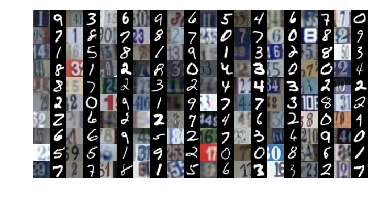

In [7]:
s, m = get_data_loader()
mnist_iter = iter(m)
svhn_iter = iter(s)
x1, y1 = svhn_iter.next()
x2, y2 = mnist_iter.next()
display(merge_images(x1, x2));

### Defining Our Models

In [8]:
class Generator(nn.Module):
    def __init__(self, c_in, c_out, conv_dim=64):
        super(Generator, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(c_in, conv_dim, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(conv_dim), nn.LeakyReLU(0.05),
            nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim*2), nn.LeakyReLU(0.05)
       )
        self.residual = nn.Sequential(
            nn.Conv2d(conv_dim*2, conv_dim*2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(conv_dim*2), nn.LeakyReLU(0.05),
            nn.Conv2d(conv_dim*2, conv_dim*2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(conv_dim*2), nn.LeakyReLU(0.05)
       )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim), nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(conv_dim, c_out, 4, 2, 1, bias=False)
        )
    def forward(self, x):
        out = self.encode(x)
#         print(out.shape)
        out = self.residual(out)
#         print(out.shape)
        out = self.decode(out)
        return F.tanh(out)
class Discriminator(nn.Module):
    def __init__(self, c_in, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(c_in, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.05),
            nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim*2), nn.LeakyReLU(0.05),
            nn.Conv2d(conv_dim*2, conv_dim*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim*4), nn.LeakyReLU(0.05)
        )
        self.conv_fc = nn.Sequential(
            nn.Conv2d(conv_dim*4, 1, 4, 1, 0, bias=False)
        )
    def forward(self, x):
        out = self.conv_layers(x);
#         print(out.shape)
        out = self.conv_fc(out)
#         print(out.shape)
        return out.squeeze()

### Building models

In [9]:
writer = SummaryWriter(log_dir='./log')

In [10]:
G_MS = Generator(1, 3, params['gen_filters'])
G_SM = Generator(3, 1, params['gen_filters'])
D_M = Discriminator(1, params['disc_filters'])
D_S = Discriminator(3, params['disc_filters'])
if params['use_saved']['g_ms']:
    G_MS.load_state_dict(torch.load(params['g_ms_path']))
    print("Loaded {} from saved {}.".format('G_MS', params['g_ms_path']))
if params['use_saved']['g_sm']:
    G_SM.load_state_dict(torch.load(params['g_sm_path']))
    print("Loaded {} from saved {}.".format('G_SM', params['g_sm_path']))
if params['use_saved']['d_m']:
    D_M.load_state_dict(torch.load(params['d_m_path']))
    print("Loaded {} from saved {}.".format('D_M', params['d_m_path']))
if params['use_saved']['d_s']:
    D_S.load_state_dict(torch.load(params['d_s_path']))
    print("Loaded {} from saved {}.".format('D_S', params['d_s_path']))
# writer.add_graph(G_MS)
# writer.add_graph(G_SM)
# writer.add_graph(D_M)
# writer.add_graph(D_S)

Loaded G_MS from saved ./saved_model/g_ms/g_ms_100.
Loaded G_SM from saved ./saved_model/g_sm/g_sm_100.
Loaded D_M from saved ./saved_model/d_m/d_m_100.
Loaded D_S from saved ./saved_model/d_s/d_s_100.


In [11]:
g_opt = optim.Adam(list(G_SM.parameters()) + list(G_MS.parameters()), params['lr'], [params['beta1'], params['beta2']])
d_opt = optim.Adam(list(D_M.parameters()) + list(D_S.parameters()), params['lr'], [params['beta1'], params['beta2']])
criterion = nn.CrossEntropyLoss()

In [ ]:
if config['use_cuda']:
    G_MS.cuda()
    G_SM.cuda()
    D_M.cuda()
    D_S.cuda() 

### Training

In [ ]:
svhn_dataloader, mnist_dataloader = get_data_loader() 
svhn_iter = iter(svhn_dataloader)
mnist_iter = iter(mnist_dataloader)

test_svhn = svhn_iter.next()[0]
test_mnist = mnist_iter.next()[0]

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6b34f50e80>>
Traceback (most recent call last):
  File "/opt/intelpython3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/opt/intelpython3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/opt/intelpython3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/opt/intelpython3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/intelpython3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/opt/intelpython3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Clie

In [ ]:
test_mnist.shape, test_svhn.shape

(torch.Size([100, 1, 32, 32]), torch.Size([100, 3, 32, 32]))

In [ ]:
total_data = mnist_dataloader.dataset.train_data.shape[0]
svhn_dataloader.dataset.data.shape,mnist_dataloader.dataset.train_data.shape

((73257, 3, 32, 32), torch.Size([60000, 28, 28]))

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [ ]:
num_iters = total_data // config['batch_size']
# start_epoch = model_number // 
print("No of iterations per epoch: ", num_iters)
for ep in range(config['num_epochs']):
#     pass
    svhn_iter = iter(svhn_dataloader)
    mnist_iter = iter(mnist_dataloader)
    for itn in range(num_iters):
        batch_svhn, _ = svhn_iter.next()
        batch_mnist, _ = mnist_iter.next()
        if config['use_cuda']:
            batch_svhn = batch_svhn.cuda()
            batch_mnist = batch_mnist.cuda()
        
        # training D
        # REAL images
        g_opt.zero_grad()
        d_opt.zero_grad()
        output = D_M(batch_mnist)
        m_loss = torch.mean((output-1)**2)
        output = D_S(batch_svhn)
        s_loss = torch.mean((output-1)**2)
        d_loss_real = m_loss + s_loss
        d_loss_real.backward()
        d_opt.step()
        
        # FAKE images
        g_opt.zero_grad()
        d_opt.zero_grad()
        fake_svhn = G_MS(batch_mnist)
        fake_mnist = G_SM(batch_svhn)
        output = D_M(fake_mnist)
        m_loss = torch.mean(output**2)
        output = D_S(fake_svhn)
        s_loss = torch.mean(output**2)
        d_loss_fake = m_loss + s_loss
        d_loss_fake.backward()
        d_opt.step()
        
        # training G
        # MNIST to SVHN to MNIST cycle
        g_opt.zero_grad()
        d_opt.zero_grad()
        fake_svhn = G_MS(batch_mnist)
        cyclic_mnist = G_SM(fake_svhn)
        decision = D_S(fake_svhn)
        g_msm_loss = torch.mean((decision-1)**2)
        g_msm_loss += torch.mean((batch_mnist - cyclic_mnist)**2)
        g_msm_loss.backward()
        g_opt.step()
        
        # SVHN to MNIST to SVHN cycle
        g_opt.zero_grad()
        d_opt.zero_grad()
        fake_mnist = G_SM(batch_svhn)
        cyclic_svhn = G_MS(fake_mnist)
        decision = D_M(fake_mnist)
        g_sms_loss = torch.mean((decision-1)**2)
        g_sms_loss += torch.mean((batch_svhn - cyclic_svhn)**2)
        g_sms_loss.backward()
        g_opt.step()
        
        if(itn%10 == 0):
            writer.add_scalars('D_Loss', {
                                'real':d_loss_real.data[0], 
                                'mnist':m_loss.data[0], 
                                'svhn':s_loss.data[0], 
                                'fake':d_loss_fake.data[0]})
            writer.add_scalars('G_Loss', {
                            'MSM':g_msm_loss.data[0],  
                            'SMS':g_sms_loss.data[0] 
        })
        if(itn % 100 == 0):
            print("Ep:" +str(ep) +
                  " Step:" + str(itn) +
                  " D_real:"+str(d_loss_real.cpu().data.numpy()) +
                  " D_fake:"+str(d_loss_fake.cpu().data.numpy()) +
                  " MSM:"+str(g_msm_loss.cpu().data.numpy()) +
                  " SMS:"+str(g_sms_loss.cpu().data.numpy())
                 )
            # Saving models for future use
            iteration_number = ep*num_iters+itn
            g_ms = osp.join(config['model_path'], 'g_ms', 'g_ms_%d'%(iteration_number))
            g_sm = osp.join(config['model_path'], 'g_sm', 'g_sm_%d'%(iteration_number))
            d_s = osp.join(config['model_path'], 'd_s', 'd_s_%d'%(iteration_number))
            d_m = osp.join(config['model_path'], 'd_m', 'd_m_%d'%(iteration_number))
            torch.save(G_MS.state_dict(), g_ms)
            torch.save(G_SM.state_dict(), g_sm)
            torch.save(D_S.state_dict(), d_s)
            torch.save(D_M.state_dict(), d_m)
            
            # Saving test images
            dirc = config['images_path']
            fake_mnist = G_SM(test_svhn.cuda())
            cyclic_svhn = G_MS(fake_mnist)
            fake_svhn = G_MS(test_mnist.cuda())
            cyclic_mnist = G_SM(fake_svhn)
            
            path = osp.join(dirc, 'svhn2mnist', 's-m-%d.png'%(iteration_number))
            merged = merge_images(test_svhn, fake_mnist.cpu().data.numpy())
            Misc.imsave(path, merged)
            
            path = osp.join(dirc, 'mnist2svhn', 'm-s-%d.png'%(iteration_number))
            merged = merge_images(test_mnist, fake_svhn.cpu().data.numpy())
            Misc.imsave(path, merged)
            
            path = osp.join(dirc, 'svhn2svhn', 's-s-%d.png'%(iteration_number))
            merged = merge_images(test_svhn, cyclic_svhn.cpu().data.numpy())
            Misc.imsave(path, merged)
            
            path = osp.join(dirc, 'mnist2mnist', 'm-m-%d.png'%(iteration_number))
            merged = merge_images(test_mnist, cyclic_mnist.cpu().data.numpy())
            Misc.imsave(path, merged)
            
#               D_mnist:{m_loss.data[0]}, \
#               D_svhn:{s_loss.data[0]}, \

No of iterations per epoch:  600


/opt/intelpython3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: invalid index of a 0-dim tensor. Thi

Ep:0 Step:0 D_real:0.3148807883262634 D_fake:0.5653722286224365 MSM:0.881912887096405 SMS:1.339260458946228
Ep:0 Step:100 D_real:0.06890599429607391 D_fake:0.17002122104167938 MSM:1.9223992824554443 SMS:1.402418851852417
Ep:0 Step:200 D_real:0.11679847538471222 D_fake:0.06619549542665482 MSM:1.3496005535125732 SMS:0.9578174352645874
Ep:0 Step:300 D_real:0.2590690553188324 D_fake:0.11369581520557404 MSM:1.4685381650924683 SMS:1.2819366455078125
Ep:0 Step:400 D_real:0.14122804999351501 D_fake:0.10718175768852234 MSM:1.351871132850647 SMS:1.1165931224822998
Ep:0 Step:500 D_real:0.16489362716674805 D_fake:0.10153079777956009 MSM:1.3584678173065186 SMS:1.002357006072998
Ep:1 Step:0 D_real:0.17474199831485748 D_fake:0.22800375521183014 MSM:1.6750903129577637 SMS:1.1084201335906982
Ep:1 Step:100 D_real:0.178672656416893 D_fake:0.09068471193313599 MSM:1.451255202293396 SMS:0.9215854406356812
Ep:1 Step:200 D_real:0.10768194496631622 D_fake:0.16088436543941498 MSM:1.6150773763656616 SMS:1.120365

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6acedab198>>
Traceback (most recent call last):
  File "/opt/intelpython3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/opt/intelpython3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/opt/intelpython3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/opt/intelpython3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/intelpython3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/opt/intelpython3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Clie

Ep:8 Step:0 D_real:0.05158150941133499 D_fake:0.08337850868701935 MSM:1.4254871606826782 SMS:1.148031234741211
Ep:8 Step:100 D_real:0.15571193397045135 D_fake:0.05051066726446152 MSM:1.209216833114624 SMS:1.2780405282974243
Ep:8 Step:200 D_real:0.10642284154891968 D_fake:0.05046538636088371 MSM:1.079516053199768 SMS:1.1730173826217651
Ep:8 Step:300 D_real:0.19743643701076508 D_fake:0.060033902525901794 MSM:1.1260353326797485 SMS:1.2333160638809204
Ep:8 Step:400 D_real:0.07005997002124786 D_fake:0.07506398111581802 MSM:1.488248348236084 SMS:1.1018602848052979
Ep:8 Step:500 D_real:0.06663470715284348 D_fake:0.05850449949502945 MSM:1.229851484298706 SMS:1.0354063510894775
Ep:9 Step:0 D_real:0.06507562845945358 D_fake:0.09342887252569199 MSM:1.5661191940307617 SMS:1.2682493925094604
Ep:9 Step:100 D_real:0.08272591233253479 D_fake:0.05707314610481262 MSM:1.2708358764648438 SMS:1.4223788976669312
Ep:9 Step:200 D_real:0.10368244349956512 D_fake:0.03635428100824356 MSM:1.1379622220993042 SMS:1